<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

**Цель:** сохранять текущих клиентов.

**Задача:** 
- спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 
- построить модель с предельно большим значением *F1*-меры. Нужно довести метрику до 0.59. 
- Дополнительно измерить *AUC-ROC*, сравнить её значение с *F1*-мерой.

**Данные:* предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

*Признаки*
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

*Целевой признак*
- Exited — факт ухода клиента

## Подготовка данных

Импортируем библиотеки и ознакомимся с данными.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, mean_squared_error, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


sns.set(style="darkgrid")
%matplotlib inline

In [4]:
frame = pd.read_csv("/datasets/Churn.csv")

In [5]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Столбец `Tenure` содержит около 10% пропущенных значений, их нужно будет заполнить.
<hr>
Изучим значения статистик и проверим на наличие дубликатов.

In [6]:
frame.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [7]:
frame.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Четверть клиентов имеет нулевой баланс, тоже самое касается признака активности. Возможно здесь есть связь.

In [8]:
display("Количесвто дубликатов:",frame.duplicated().sum())

'Количесвто дубликатов:'

0

<hr>
Фамилия, айди и номер строки - лишние столбцы, удалим их.

In [9]:
frame = frame.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)

Переименуем столбцы и приведем к одному регистру.

In [10]:
frame.columns = frame.columns.str.lower()
frame.columns

Index(['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary',
       'exited'],
      dtype='object')

In [11]:
frame.rename({'creditscore': 'credit_score',
             'geography': 'country',
             'isactivemember': 'is_active',
             'numofproducts': 'num_of_products',
             'hascrcard': 'has_cr_card',
             'estimatedsalary': 'salary',
             'exited': 'churn'}, axis=1, inplace=True)


**Обработка пропусков**

В столбце `tenure` есть пропуски. Поищем аномалии среди этих клиентов.

In [12]:
frame.query('tenure.isna()').describe()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active,salary,churn
count,909.000000,909.000000,0.0,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000
mean,648.451045,38.647965,NaN,76117.341474,1.530253,0.710671,0.510451,99180.389373,0.201320
std,99.079381,9.785438,NaN,63105.690715,0.588452,0.453701,0.500166,56378.063765,0.401207
min,359.000000,18.000000,NaN,0.000000,1.000000,0.000000,0.000000,106.670000,0.000000
25%,580.000000,32.000000,NaN,0.000000,1.000000,0.000000,0.000000,49872.330000,0.000000
50%,647.000000,37.000000,NaN,96674.550000,1.000000,1.000000,1.000000,99444.020000,0.000000
75%,718.000000,43.000000,NaN,128554.980000,2.000000,1.000000,1.000000,145759.700000,0.000000
max,850.000000,92.000000,NaN,206663.750000,4.000000,1.000000,1.000000,199390.450000,1.000000


Очевидных аномалий я не нашёл, поделим выборку на пять возрастных групп и заполним медианным значением внутри каждой из групп все пропуски.

In [13]:
frame['group_age'] = pd.qcut(frame['age'], 5)
display(frame['group_age'].value_counts().sort_index())

(17.999, 31.0]    2372
(31.0, 35.0]      1781
(35.0, 40.0]      2266
(40.0, 46.0]      1696
(46.0, 92.0]      1885
Name: group_age, dtype: int64

In [14]:
frame_del_drop = frame.copy()
frame_del_drop = frame_del_drop.dropna()
frame_del_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 12 columns):
credit_score       9091 non-null int64
country            9091 non-null object
gender             9091 non-null object
age                9091 non-null int64
tenure             9091 non-null float64
balance            9091 non-null float64
num_of_products    9091 non-null int64
has_cr_card        9091 non-null int64
is_active          9091 non-null int64
salary             9091 non-null float64
churn              9091 non-null int64
group_age          9091 non-null category
dtypes: category(1), float64(3), int64(6), object(2)
memory usage: 861.4+ KB


In [15]:
frame['tenure'] = frame.groupby(
        ['country',
         'gender',
         'group_age']
)['tenure'].transform(lambda x: x.fillna(x.median()))

In [16]:
frame['tenure'] = frame['tenure'].astype('int')
frame = frame.drop('group_age', axis=1)
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
credit_score       10000 non-null int64
country            10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             10000 non-null int64
balance            10000 non-null float64
num_of_products    10000 non-null int64
has_cr_card        10000 non-null int64
is_active          10000 non-null int64
salary             10000 non-null float64
churn              10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Поправили типы данных, удалили ненужный стобец с возрастной группой, проверили названия, пропуски - всё ок, двигаемся дальше.
<hr>
Построим графики распределения по кредитному скорингу, возрасту, остатку на счетах, заработной плате и изучим зависимости.

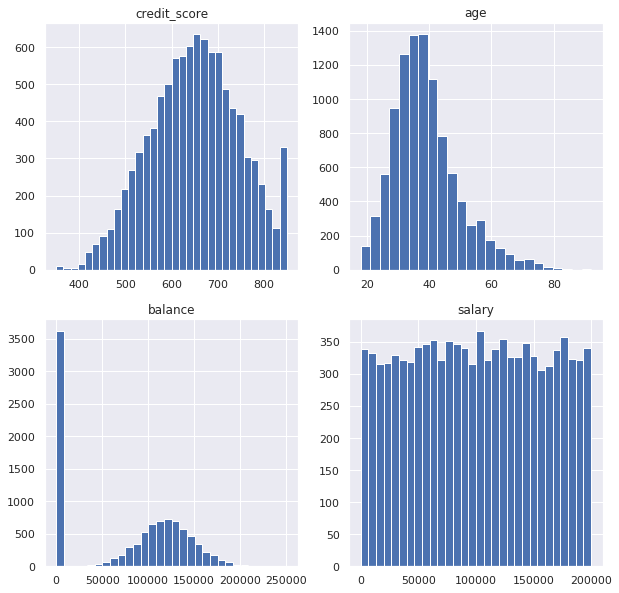

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].hist(frame['credit_score'], bins=32)
axes[0, 0].set_title("credit_score")
axes[0, 1].hist(frame['age'], bins=24)
axes[0, 1].set_title("age")
axes[1, 0].hist(frame['balance'], bins=30)
axes[1, 0].set_title("balance")
axes[1, 1].hist(frame['salary'], bins=30)
axes[1, 1].set_title("salary");

Распределение таких характеристик близки к нормальному. При этом мы можем видеть, что распределение зарплат довольно однородное. Это говорит о том, что, вероятно, выборка стратифицирована.

Есть подозрительный выброс в районе нуля на графике балансов. Удалять мы его не будем, нет причин полагать, что это ошибка, скорее всего этот критерий будет очень важен для модели. Интересно, что нет клиентов с нулевым балансом из Германии. Во франции таких вдвое больше, но это обсуловлено тем, что и самих клиентов из Франции практически вдвое больше. 

In [18]:
frame[frame['balance'] == 0].groupby(['country', 'is_active'])['churn'].agg('count')

country  is_active
France   0            1158
         1            1260
Spain    0             586
         1             613
Name: churn, dtype: int64

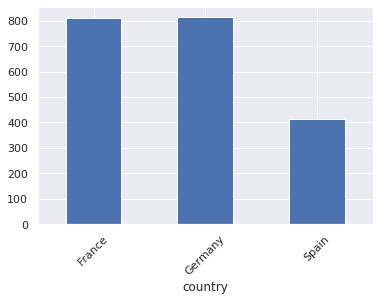

In [19]:
(frame[frame['churn'] == 1].groupby(['country'])['churn'].count()).plot(kind='bar', rot=45)

Больше всего отток клиентов из Франции и Германии, Испания имеет вдвое меньший показатель.

In [20]:
pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.2)
Note: you may need to restart the kernel to use updated packages.


Text(0.5, 1.0, 'Баланс на момент оттока')

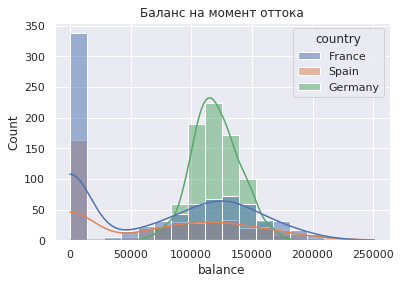

In [21]:
sns.histplot(data=frame[frame['churn'] == 1], x='balance', kde=True, hue='country')

plt.title('Баланс на момент оттока')

**Выводы**

Обработали имеющиеся данные: поправили названия, убрали лишние столбцы, заполнили пропуски медианным значением по возрастной группе.

Выборка состоит:
- 50% клиенты из Фарнции
- 25% клиенты из Германии
- 25% клиенты из Испании

Интересно, что среди оттока немцев нет клиентов с нулевым балансом, а значительная часть клиентов в оттоке как раз имеет нулевой баланс. Меньше всего банк покинуло клиентов из Испании. 

Обработаем признаки со страной и полом с помощью дамми-кодирования.

In [20]:
frame = pd.get_dummies(frame, drop_first=True)

Также необходимо привести некоторые признаки к единой размрности для более корректной работы моделей.

- credit_score
- age
- tenure
- balance
- num_of_products
- salary

## Исследование задачи

In [21]:
frame.churn.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: churn, dtype: float64

Есть дисбаланс класса, который нужно предсказать, пропорция 80 на 20.

Подготовим данные для обучения на простейшей модели и сравним её со случайной, пока без учёта дисбаланса.

*Создадим обучающую, тестовую и валидационные выборки в соотношении 3:1:1*

In [22]:
def post_normalize(frame):
    to_norm = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'salary']
    scaler = MinMaxScaler()
    scaler.fit(frame[to_norm])
    frame.loc[:, to_norm] = scaler.transform(frame[to_norm])
    
    return frame

In [23]:
pd.options.mode.chained_assignment = None

target = frame['churn']
features = frame.drop('churn', axis=1)

def get_samples(target, features, size):
    '''
    Принимает на вход: целевой признак, отобранные фичи, доля тестовых данных.
    
    Возвращает: разделённые выборки в указанной пропорции.
    '''
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=size, random_state=42, stratify=target
    )
        
    return post_normalize(features_train), post_normalize(features_valid), target_train, target_valid
    
features_train, features_valid, target_train, target_valid = get_samples(target, features, 0.4)
features_test, features_valid, target_test, target_valid = get_samples(target_valid, features_valid, 0.5)

print(f'Размер тестовой выборки = {features_test.shape}')
print(f'Размер валидационной выборки = {features_valid.shape}')
print(f'Размер обучающей выборки = {features_train.shape}')

Размер тестовой выборки = (2000, 11)
Размер валидационной выборки = (2000, 11)
Размер обучающей выборки = (6000, 11)


Для удобства сравнения моделей создадим фрейм:
- 'model' - имя модели,
- f1_valid'- f1 на валидационной выборке,
- 'roc_auc' - ROC-AUC на выборке,
- 'balanced' - сбалансирован ли класс.

In [24]:
results = pd.DataFrame(columns=[
                              'model',
                              'f1_valid',
                              'roc_auc',
                              'balanced'])

In [25]:
def get_actual_auc(model, target_valid, features_valid):
    '''
    Принимает на вход: обученную модель, валидационную выборку.
    
    Возвращает: 
    - площадь, ограниченную рабочей характеристикой приёмника,
    - процент верно предсказанных среди положительных значений,
    - процент неверно предсказанных среди отрицательных значений,
    - пороговые значения.
    '''
    probabilities = model.predict_proba(features_valid)

    fpr, tpr, thresholds = roc_curve(target_valid, probabilities[:,1])
    auc_roc = roc_auc_score(target_valid, probabilities[:,1])
    
    return auc_roc, fpr, tpr, thresholds

def show_roc(fpr, tpr, auc_roc):
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC кривая (area = %0.2f)' % auc_roc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc="lower right")
    plt.grid(color = 'black')
    plt.show()

**Модель случайного леса**

In [26]:
def get_best_random_forest(features_train, target_train, features_valid, target_valid, class_weight='balanced'):
    '''
    Принимает на вход: обучающую и валидационную выборки, режим корректировки веса классов.
    
    Возвращает: 
    - площадь, ограниченную рабочей характеристикой приёмника,
    - процент верно предсказанных среди положительных значений,
    - процент неверно предсказанных среди отрицательных значений,
    - пороговые значения.
    '''
    f1_dict = {a : [] for a in range(100, 136, 1)}
    auc_dict = {a : [] for a in range(100, 136, 1)}
    best_f1 = 0

    for n_est in f1_dict:
        for depth in range(15, 20):
            model = RandomForestClassifier(random_state=42, max_depth=depth, n_estimators=n_est, class_weight=class_weight)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            actual_f1 = f1_score(target_valid, predictions)
            
            auc_roc, fpr, tpr, thresholds = get_actual_auc(model, target_valid, features_valid)
            auc_dict[n_est].append(auc_roc)
            
            if actual_f1 > best_f1:
                best_f1 = actual_f1
                best_model = model

            f1_dict[n_est].append(actual_f1)
    
    print(f'Лучшая точность на валидационной выборке: {best_f1:.4f}')
    params = best_model.get_params()
    print(f"Параметры лучшей модели: max_depth = {params['max_depth']}, n_estimators = {params['n_estimators']}")
    
    return best_model

In [27]:
best_model = get_best_random_forest(features_train, target_train, features_valid, target_valid)

Лучшая точность на валидационной выборке: 0.5941
Параметры лучшей модели: max_depth = 15, n_estimators = 120


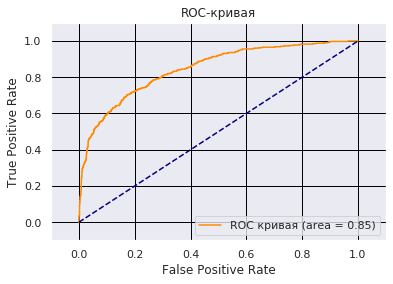

In [28]:
auc_roc, fpr, tpr, thresholds = get_actual_auc(best_model, target_valid, features_valid)
show_roc(fpr, tpr, auc_roc)

In [29]:
results = results.append(
                         {'model':'RandomForestClassifier',
                          'f1_valid':0.5941,
                          'roc_auc':0.85,
                          'balanced':False},ignore_index=True
)

**Логистическая регрессия**

Лучшая точность на валидационной выборке: 0.3105


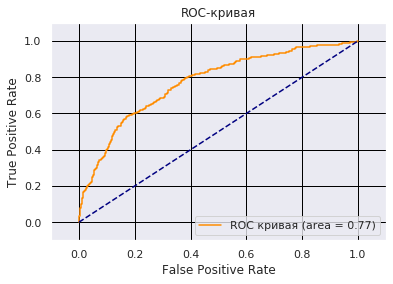

In [30]:
def get_logistic_regression(features_train, target_train, features_valid, target_valid):
    
    best_model = LogisticRegression(random_state=42, solver='liblinear', max_iter=200)
    
    best_model.fit(features_train, target_train)
    predictions = best_model.predict(features_valid)
    
    print(f'Лучшая точность на валидационной выборке: {f1_score(target_valid, predictions):.4f}')
    return best_model
    
best_logist_model = get_logistic_regression(features_train, target_train, features_valid, target_valid)

auc_roc, fpr, tpr, thresholds = get_actual_auc(best_logist_model, target_valid, features_valid)
show_roc(fpr, tpr, auc_roc)

In [31]:
results = results.append(
                         {'model':'LogisticRegression',
                          'f1_valid':0.3105,
                          'roc_auc':0.77,
                          'balanced':False},ignore_index=True
)

Модель логистической регрессии справилась хуже. Это видно по метрикам AUC и F1/

Выяснили, что экземлпяров одного класса больше в 4 раза, чем другого класса. Перейдём к обучению с учётом дисбаланса классов. Также заметно, что модель случайного леса проявила себя лучше на обучении без учета дисбаланса.

## Борьба с дисбалансом

Увеличим выборку меньшего класса в 4 раза.

In [32]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

features_train, features_valid, target_train, target_valid = get_samples(target, features, 0.4)
features_test, features_valid, target_test, target_valid = get_samples(target_valid, features_valid, 0.5)

features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 3)

display(len(features_train_upsampled) / len(target_train_upsampled), 'отношение количества элементов положительного и отрицательного класса равно единице.')

1.0

'отношение количества элементов положительного и отрицательного класса равно единице.'

In [33]:
best_forest_model = get_best_random_forest(features_train_upsampled, target_train_upsampled, features_valid, target_valid)

Лучшая точность на валидационной выборке: 0.6068
Параметры лучшей модели: max_depth = 16, n_estimators = 100


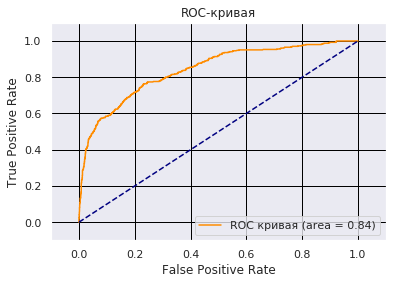

In [34]:
auc_roc, fpr, tpr, thresholds = get_actual_auc(best_forest_model, target_valid, features_valid)
show_roc(fpr, tpr, auc_roc)

Получилось увеличить точность F1 Метрики. ROC кривая практически такая же. Тем не менее попробуем уменьшить больший класс в 2 раза и увеличить в 2 раза меньший класс. Сохраним модель отдельно.

In [35]:
results = results.append(
                         {'model':'RandomForestClassifier',
                          'f1_valid':0.6068,
                          'roc_auc':0.84,
                          'balanced':'Positive x 4'},ignore_index=True
)

In [36]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

In [37]:
features_train, features_valid, target_train, target_valid = get_samples(target, features, 0.4)
features_test, features_valid, target_test, target_valid = get_samples(target_valid, features_valid, 0.5)

features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.5)
features_train_combined, target_train_combined = upsample(features_train_downsampled, target_train_downsampled, 2)


In [38]:
best_forest_model = get_best_random_forest(features_train_combined, target_train_combined, features_valid, target_valid)

Лучшая точность на валидационной выборке: 0.6013
Параметры лучшей модели: max_depth = 17, n_estimators = 128


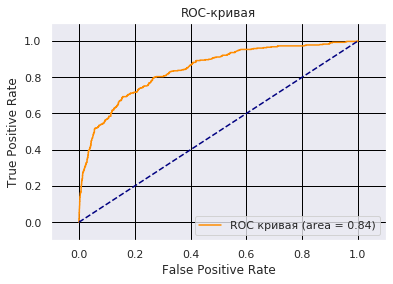

In [39]:
auc_roc, fpr, tpr, thresholds = get_actual_auc(best_forest_model, target_valid, features_valid)
show_roc(fpr, tpr, auc_roc)

In [40]:
results = results.append(
                         {'model':'RandomForestClassifier',
                          'f1_valid':0.6013,
                          'roc_auc':0.84,
                          'balanced':'Negative / 2, Positive x 2'},ignore_index=True
)

Попробуем уменьшить больший класс в четыре раза.

In [41]:
features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.25)

best_forest_model1 = get_best_random_forest(features_train_downsampled, target_train_downsampled, features_valid, target_valid)

Лучшая точность на валидационной выборке: 0.5798
Параметры лучшей модели: max_depth = 15, n_estimators = 132


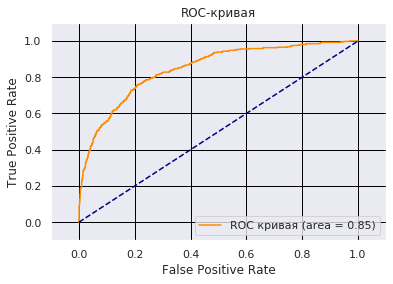

In [42]:
auc_roc, fpr, tpr, thresholds = get_actual_auc(best_forest_model1, target_valid, features_valid)
show_roc(fpr, tpr, auc_roc)

In [43]:
results = results.append(
                         {'model':'RandomForestClassifier',
                          'f1_valid':0.5798,
                          'roc_auc':0.85,
                          'balanced':'Negative / 4'},ignore_index=True
)

Лучшая точность была при использорвании комбинированного способа решения проблемы дисбаланса.

Лучшая точность на валидационной выборке: 0.4874


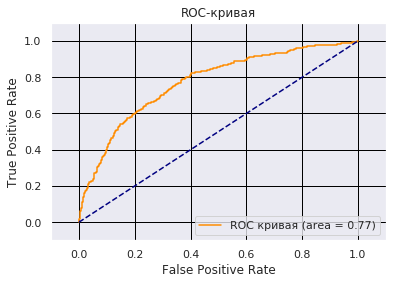

In [44]:
best_logist_model = get_logistic_regression(features_train_combined, target_train_combined, features_valid, target_valid)

auc_roc, fpr, tpr, thresholds = get_actual_auc(best_logist_model, target_valid, features_valid)
show_roc(fpr, tpr, auc_roc)

In [45]:
results = results.append(
                         {'model':'LogisticRegression',
                          'f1_valid':0.4874,
                          'roc_auc':0.77,
                          'balanced':'Negative / 2, Positive x 2'},ignore_index=True
)

Логистическая регрессия показала себя значительно хуже случайного леса, остановимся на нём.

С лучшим порогом (0.5000000000000002) значение метрики F1 = 0.6012793176972282


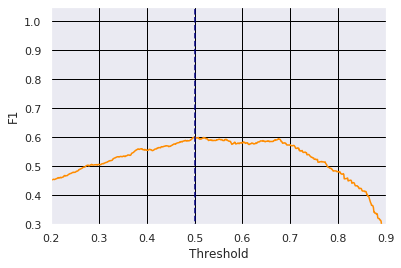

In [46]:
probabilities_valid = best_forest_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

list_threshold = []
best_threshold = 0
actual_f1 = 0
best_f1 = 0
max_range = 0.9
min_range = 0.2
range_threshold = np.arange(min_range, max_range, 0.001)

for threshold in range_threshold:
    predictions = probabilities_one_valid > threshold
    actual_f1 = f1_score(target_valid, predictions)
    if actual_f1 > best_f1:
        best_f1 = actual_f1
        best_threshold = threshold
    list_threshold.append(actual_f1)
    
print(f'С лучшим порогом ({best_threshold}) значение метрики F1 = {best_f1}')


plt.plot(range_threshold.tolist(), list_threshold, color='darkorange')
plt.plot([best_threshold, best_threshold], [0, 1.05], color='navy', linestyle='--')
plt.grid(color='black')
plt.xlim([min_range, max_range])
plt.ylim([0.3, 1.05])
plt.xlabel('Threshold')
plt.ylabel('F1')
plt.show()

F1 = 0.6013


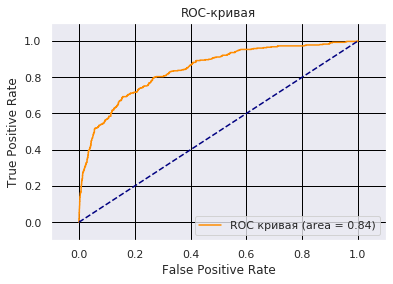

In [47]:
probabilities = best_forest_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

predictions = probabilities_one_valid > best_threshold

print(f'F1 = {f1_score(target_valid, predictions):.4f}')

auc_roc, fpr, tpr, thresholds = get_actual_auc(best_forest_model, target_valid, features_valid)
show_roc(fpr, tpr, auc_roc)

In [48]:
results = results.append(
                         {'model':'RandomForestClassifier',
                          'f1_valid':0.6013,
                          'roc_auc':0.84,
                          'balanced':'Negative / 2, Positive x 2, Best Threshold'},ignore_index=True
)

Результат удовлетворительный, переходим к тестированию.

## Тестирование модели

F1 = 0.5893


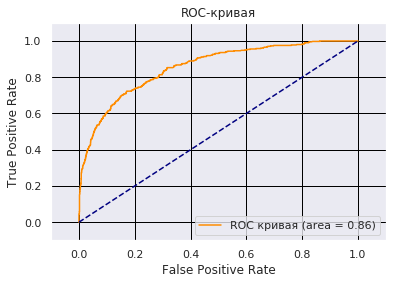

In [49]:
probabilities = best_forest_model.predict_proba(features_test)
probabilities_one_valid = probabilities[:, 1]

predictions = probabilities_one_valid > best_threshold

print(f'F1 = {f1_score(target_test, predictions):.4f}')

auc_roc, fpr, tpr, thresholds = get_actual_auc(best_forest_model, target_test, features_test)
show_roc(fpr, tpr, auc_roc)

In [50]:
results = results.append(
                         {'model':'RandomForestClassifier (test)',
                          'f1_valid':0.5893,
                          'roc_auc':0.86,
                          'balanced':'Negative / 2, Positive x 2, Best Threshold'},ignore_index=True
)

In [51]:
results

,model,f1_valid,roc_auc,balanced
0,RandomForestClassifier,0.5941,0.85,False
1,LogisticRegression,0.3105,0.77,False
2,RandomForestClassifier,0.6068,0.84,Positive x 4
3,RandomForestClassifier,0.6013,0.84,"Negative / 2, Positive x 2"
4,RandomForestClassifier,0.5798,0.85,Negative / 4
5,LogisticRegression,0.4874,0.77,"Negative / 2, Positive x 2"
6,RandomForestClassifier,0.6013,0.84,"Negative / 2, Positive x 2, Best Threshold"
7,RandomForestClassifier (test),0.5893,0.86,"Negative / 2, Positive x 2, Best Threshold"


In [52]:
features_all = features_train.append(features_valid)
features_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 6851 to 7634
Data columns (total 11 columns):
credit_score       8000 non-null float64
age                8000 non-null float64
tenure             8000 non-null float64
balance            8000 non-null float64
num_of_products    8000 non-null float64
has_cr_card        8000 non-null int64
is_active          8000 non-null int64
salary             8000 non-null float64
country_Germany    8000 non-null uint8
country_Spain      8000 non-null uint8
gender_Male        8000 non-null uint8
dtypes: float64(6), int64(2), uint8(3)
memory usage: 585.9 KB


In [53]:
model_all = RandomForestClassifier(random_state=42, max_depth=17, n_estimators=128, class_weight='balanced')
model_all.fit(features_train_combined, target_train_combined)
predictions = model_all.predict(features_valid)
actual_f1 = f1_score(target_valid, predictions)

F1 = 0.5893


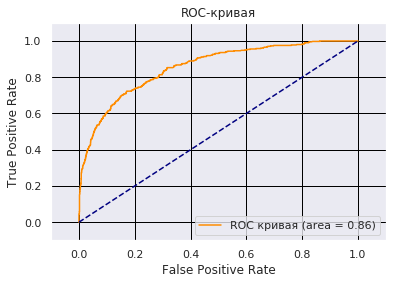

In [55]:
probabilities = model_all.predict_proba(features_test)
probabilities_all = probabilities[:, 1]

predictions = probabilities_all > best_threshold

print(f'F1 = {f1_score(target_test, predictions):.4f}')

auc_roc, fpr, tpr, thresholds = get_actual_auc(model_all, target_test, features_test)
show_roc(fpr, tpr, auc_roc)

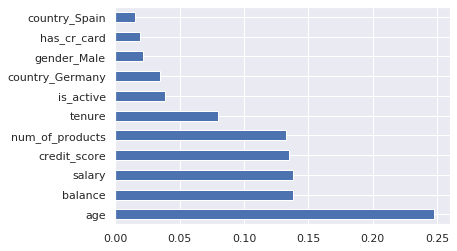

In [57]:
feat_importances1 = pd.Series(best_forest_model.feature_importances_, index=features_train_combined.columns)
feat_importances1.nlargest(20).plot(kind='barh')
plt.show()

**Общий вывод**

Наш итоговый результат: F1 = 0.5893, AUC = 0.86

Мы смогли добиться этого, уменьшив больший класс вдвое, и увеличив меньший класс также вдвое. Подобрали оптимальное значение порога. Наилучим образом отработала модель случайного леса.

Если учитывать показатели метрики F-меры, то модель, с учетом балансировки, делает прогнозы лучше, чем без учета. На метрику ROC-AUC балансировка не повлияла.

Для более адекватной оценки модели, необходим отдельный тестовый набор данных. Службе маркетинга можем рекомендовать взять данную модель для пронозирования оттока на тестирование на реальных данных. 